# Gaussian Processes 

`conda install plotly`

Consider a simple function



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

np.random.seed(2)
def f(x):
    """The function to predict."""
    return x * np.sin(x)

<ErrorbarContainer object of 3 artists>

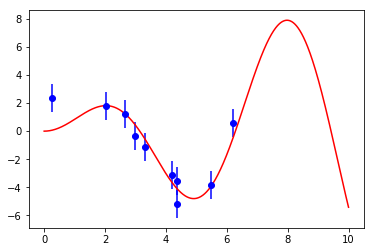

In [2]:
xmax = 10
X_space = np.linspace(0.001, xmax - 0.001, 1000)

# Get the "real" value
y_real = f(X_space)

n = 10
# Uniform sampling and add Gaussian noise
x_sample = np.random.random(n)*10

sigma = 1.0
noise = np.random.normal(0, sigma, n)
y_meas = f(x_sample) + noise

plt.plot(X_space,y_real,"r")
plt.errorbar(x_sample,y_meas,yerr=sigma,fmt="bo")

### Probabilistic interpretation
Let our samples be $x_i, y_i$, $i \in [0,n]$, then the probability of value $\hat{y}_i$ at position $x_i$ given the noisy $y_i$ is:
$$ Pr(Y_i = \hat{y}_i | y_i) = \mathcal{N}(\hat{y}_i; y_i,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}exp\left(\frac{-(y_i - \hat{y}_i)^2}{2\sigma^2}\right) $$

If we assume that every sample is **independent** of the other (which are not!), then the probability becomes trivialy a **multivariate Gaussian distribution** with diagonal covariance
$$ \mathbf{Y} \sim \prod_i Pr(Y_i = \hat{y}_i | y_i, \sigma) = \mathcal{N}(\mathbf{\hat{y}}; \mathbf{y},\sigma I)$$

Following this idea, we model the $\mathbf{Y}$ random vector as a Multivariate Gaussian Distribution

$$\mathcal{N}\left( \mathbf{\hat{y}}; \boldsymbol{\mu},\Sigma \right) = \frac{1}{\sqrt{(2\pi )^{k}|\Sigma}|} exp\left(-\frac{1}{2}(\boldsymbol{\mu} - \mathbf{\hat{y}})^{\mathrm{T}}\Sigma^{-1}(\boldsymbol{\mu} - \mathbf{\hat{y}})\right)$$

where $\Sigma_{ij}$ is a value that indicates how the sample $i$ varies w.r.t. $j$. 

If we interpret this model as an stochastic **process** (i.e., $x$ represent time) one would expect that samples that are closer to each other are more correlated than those that are far away, and that only depends on $x$, not $y$. One can define then a function $\Sigma_{ij} = K(x_i,x_j)$, called **Kernel**, that defines this covariance.

## Gaussian Processes

In the real world we just have the data and we want to predict a new value.


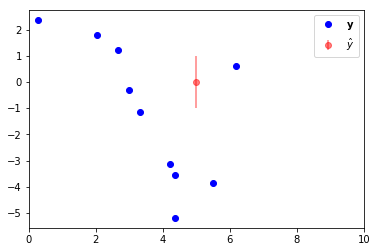

In [3]:
sigma = 1.0
y_p = 0.0
x_p = 5.0
plt.plot(x_sample,y_meas,"bo",label="$\mathbf{y}$")
plt.errorbar(x_p,y_p,yerr=sigma,fmt="ro",label="$\hat{y}$",alpha=0.5)
plt.legend()
plt.xlim(0,10)
ylim=plt.ylim()

We model the random vector (a priori) as $$\begin{bmatrix}\hat{Y} \\ \mathbf{Y} \end{bmatrix} \sim Pr\left(\begin{bmatrix}\hat{Y} \\ \mathbf{Y} \end{bmatrix} = \begin{bmatrix}\hat{y} \\ \mathbf{y} \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix}0 \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} K(\hat{x},\hat{x}) & K(\hat{x},\mathbf{x}) \\ K(\mathbf{x},\hat{x}) & K(\mathbf{x},\mathbf{x}) \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix}0 \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} a & \mathbf{b}^T \\  \mathbf{b} & C \end{bmatrix}\right) $$

(-5.570975251039949, 2.7362768371568604)

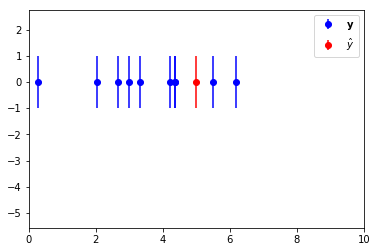

In [4]:
plt.errorbar(x_sample,np.zeros((n,1)),fmt="bo",label="$\mathbf{y}$",yerr=sigma)
plt.errorbar(x_p,0,yerr=sigma,fmt="ro",label="$\hat{y}$")
plt.legend()
plt.xlim(0,10)
plt.ylim(ylim)

### Exponential Quadratic Kernel
We define a Kernel function:

$$ \Sigma_{ij} = K(x_j,x_i) = \sigma^2 exp\left(-\frac{(x_j - x_i)^2}{2\mathcal{l}^2} \right)$$

In [5]:
x_comb = np.append(x_p,x_sample)
x_comb

array([5.        , 4.35994902, 0.25926232, 5.49662478, 4.35322393,
       4.20367802, 3.30334821, 2.04648634, 6.19270966, 2.99654674,
       2.66827275])

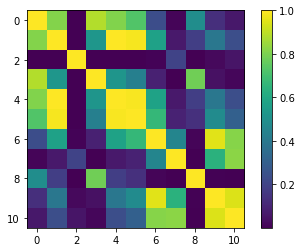

In [6]:
l = 1.0
X = np.atleast_2d(x_comb).T
M=sklearn.metrics.pairwise_distances(X,X)
S=sigma*sigma*np.exp(M*M/(-2*l*l))
plt.imshow(S)
plt.colorbar()

What we want to do is to do is to **update** this model with our data:

$$\hat{y} \sim Pr(\hat{Y}=\hat{y}| \mathbf{Y} = \mathbf{y}) = \mathcal{N}\left(\hat{y};\mathbf{b}^T C^{-1} \mathbf{y},  a - \mathbf{b}^T C^{-1} \mathbf{b} \right)$$

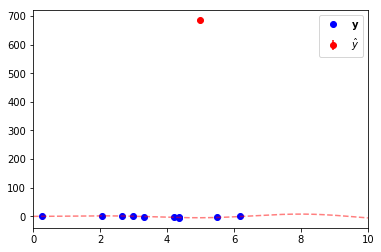

In [7]:
a = S[0,0]
b = S[0,1:]
C = S[1:,1:]
Cinv = np.linalg.inv(C)
mu_p = b.dot(Cinv).dot(y_meas)
sig_p = a - b.dot(Cinv).dot(b)
plt.plot(x_sample,y_meas,"bo",label="$\mathbf{y}$")
plt.errorbar(x_p,mu_p,yerr=sig_p,fmt="ro",label="$\hat{y}$")
plt.legend()
plt.xlim(0,10)
ylim=plt.ylim()
plt.plot(X_space,y_real,"r--",alpha=0.5)

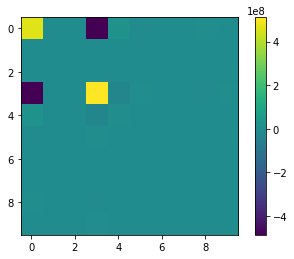

In [8]:
plt.imshow(Cinv)
plt.colorbar()

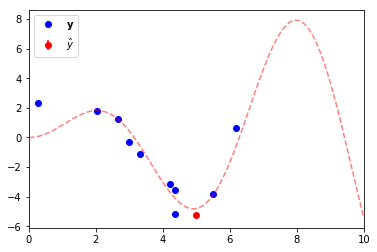

In [9]:
lamb = 0.01
Cinv = np.linalg.inv(C + lamb*np.eye(C.shape[0],C.shape[1]))
mu_p = b.dot(Cinv).dot(y_meas)
sig_p = a - b.dot(Cinv).dot(b)
plt.plot(x_sample,y_meas,"bo",label="$\mathbf{y}$")
plt.errorbar(x_p,mu_p,yerr=sig_p,fmt="ro",label="$\hat{y}$")
plt.legend()
plt.xlim(0,10)
ylim=plt.ylim()
plt.plot(X_space,y_real,"r--",alpha=0.5)

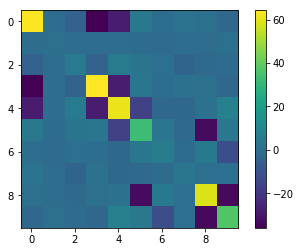

In [10]:
plt.imshow(Cinv)
plt.colorbar()

Now consider that we want to do the same but for a vector of $\mathbf{\hat{y}}$ values for the $\mathbf{\hat{x}}$ points.

$$\begin{bmatrix}\mathbf{\hat{Y}} \\ \mathbf{Y} \end{bmatrix} \sim Pr\left(\begin{bmatrix}\mathbf{\hat{Y}} \\ \mathbf{Y} \end{bmatrix} = \begin{bmatrix}\mathbf{\hat{y}} \\ \mathbf{y} \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix}\mathbf{0} \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} K(\mathbf{\hat{x}},\mathbf{\hat{x}}) & K(\mathbf{\hat{x}},\mathbf{x}) \\ K(\mathbf{x},\mathbf{\hat{x}}) & K(\mathbf{x},\mathbf{x}) + \lambda I \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix}\mathbf{0} \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} A & B^T \\  B & C \end{bmatrix}\right) $$

Now
$$\mathbf{\hat{y}} \sim Pr(\mathbf{\hat{Y}}=\mathbf{\hat{y}}| \mathbf{Y} = \mathbf{y}) = \mathcal{N}\left(\mathbf{\hat{y}} ; B^T C^{-1} \mathbf{y},  A - B^T C^{-1} B \right)$$




In [11]:
X = np.atleast_2d(x_sample).T

In [12]:
from ipywidgets import interact
X_space = np.linspace(0.1, 9.9, 1000)
X_space = np.atleast_2d(X_space).T

def gen_data(n = 10,sigma =1.0):
    # Get the "real" value
    x_sample = np.random.random(n)*10
    noise = np.random.normal(0, sigma, n)
    y_meas = f(x_sample) + noise
    X = np.atleast_2d(x_sample).T
    return(X,y_meas)

def predict_GMM_plot(lamb=0.1,sigma=1.0,l=1.0,bars=False,instances=False):
    dA=sklearn.metrics.pairwise_distances(X_space,X_space)
    dB=sklearn.metrics.pairwise_distances(X,X_space)
    dC=sklearn.metrics.pairwise_distances(X,X)
    A=sigma*sigma*np.exp(dA*dA/(-2*l*l))
    B=sigma*sigma*np.exp(dB*dB/(-2*l*l))
    C=sigma*sigma*np.exp(dC*dC/(-2*l*l))
    sI = lamb*np.eye(C.shape[0],C.shape[1])
    Cinv = np.linalg.inv(C + sI)
    mu_p = B.T.dot(Cinv).dot(y_meas)
    cov_p = A - B.T.dot(Cinv).dot(B)
    plt.plot(X,y_meas,"bo",label="$\mathbf{y}$")
    if bars:
        plt.errorbar(X_space,mu_p,yerr=1.96*np.diag(cov_p),fmt="r",label="$\mathbf{\hat{y}}$",alpha=0.2)
    else:
        plt.plot(X_space,mu_p,"r",label="$\mathbf{\hat{y}}$",alpha=0.8)
    plt.plot(X_space,y_real,"k--",alpha=0.5,label="f(x)")
    if instances:
        #L=np.linalg.cholesky(cov_p)
        for i in range(10):
            inst=np.random.multivariate_normal(mu_p, cov_p)
            #z = np.random.normal(0, 1.0, mu_p.length)
            #inst = mu_p + L.dot(z)
            plt.plot(X_space,inst,alpha=0.5)
    
    plt.legend()
    plt.xlim(0,max(X_space))
    ylim=plt.ylim() 
    


In [13]:
interact(predict_GMM_plot,lamb=(0.0,1.0,0.01),sigma=(0.1,2.0,0.1),l=(0.1,5.0,0.1))

interactive(children=(FloatSlider(value=0.1, description='lamb', max=1.0, step=0.01), FloatSlider(value=1.0, d…

<function __main__.predict_GMM_plot(lamb=0.1, sigma=1.0, l=1.0, bars=False, instances=False)>

In [14]:
X,y_meas = gen_data(n=25,sigma=1.0)
interact(predict_GMM_plot,lamb=(0.0,1.0,0.01),sigma=(0.1,4.0,0.1))

interactive(children=(FloatSlider(value=0.1, description='lamb', max=1.0, step=0.01), FloatSlider(value=1.0, d…

<function __main__.predict_GMM_plot(lamb=0.1, sigma=1.0, l=1.0, bars=False, instances=False)>

In [15]:
X_space = np.linspace(0.1, 30.0, 1000)
X_space = np.atleast_2d(X_space).T
y_real = f(X_space)
X,y_meas = gen_data(n=25,sigma=1.0)
interact(predict_GMM_plot,lamb=(0.0,1.0,0.01),sigma=(1,40.0,1),l=(0.1,4.0,0.1))

interactive(children=(FloatSlider(value=0.1, description='lamb', max=1.0, step=0.01), FloatSlider(value=1.0, d…

<function __main__.predict_GMM_plot(lamb=0.1, sigma=1.0, l=1.0, bars=False, instances=False)>

## Periodic Kernel

$K(x,x') = \sigma^2 exp\left(−\frac{2 sin^2\left(\frac{\pi(x− x′)}{p}\right)}{l^2}\right)$


In [16]:
def predict_GMMper_plot(lamb=0.1,sigma=1.0,l=1.0,p=10.0,bars=False,instances=False):
    dA=sklearn.metrics.pairwise_distances(X_space,X_space)
    dB=sklearn.metrics.pairwise_distances(X,X_space)
    dC=sklearn.metrics.pairwise_distances(X,X)
    sA=np.sin(np.pi*dA/p)
    sB=np.sin(np.pi*dB/p)
    sC=np.sin(np.pi*dC/p)
    A=sigma*sigma*np.exp(2*sA*sA/(-l*l))
    B=sigma*sigma*np.exp(2*sB*sB/(-l*l))
    C=sigma*sigma*np.exp(2*sC*sC/(-l*l))
    sI = lamb*np.eye(C.shape[0],C.shape[1])
    Cinv = np.linalg.inv(C + sI)
    mu_p = B.T.dot(Cinv).dot(y_meas)
    cov_p = A - B.T.dot(Cinv).dot(B)
    plt.plot(X,y_meas,"bo",label="$\mathbf{y}$")
    if bars:
        plt.errorbar(X_space,mu_p,yerr=1.96*np.diag(cov_p),fmt="r",label="$\mathbf{\hat{y}}$",alpha=0.2)
    else:
        plt.plot(X_space,mu_p,"r",label="$\mathbf{\hat{y}}$",alpha=0.8)
    plt.plot(X_space,y_real,"k--",alpha=0.5,label="f(x)")
    if instances:
        #L=np.linalg.cholesky(cov_p)
        for i in range(10):
            inst=np.random.multivariate_normal(mu_p, cov_p)
            #z = np.random.normal(0, 1.0, mu_p.length)
            #inst = mu_p + L.dot(z)
            plt.plot(X_space,inst,alpha=0.5)
    
    plt.legend()
    plt.xlim(0,max(X_space))
    ylim=plt.ylim() 
    

In [17]:
interact(predict_GMMper_plot,lamb=(0.0,1.0,0.01),sigma=(1,40.0,1),l=(0.1,4.0,0.1),p=(0.1,30.0,0.1))

interactive(children=(FloatSlider(value=0.1, description='lamb', max=1.0, step=0.01), FloatSlider(value=1.0, d…

<function __main__.predict_GMMper_plot(lamb=0.1, sigma=1.0, l=1.0, p=10.0, bars=False, instances=False)>

## Periodic Kernel + Exponential Quadratic

$K(x,x') = \sigma^2 exp\left(−\frac{2 sin^2\left(\frac{\pi(x− x′)}{p}\right)}{l^2}\right) \sigma^2 exp\left(-\frac{(x_j - x_i)^2}{2\mathcal{l}^2} \right) $

In [ ]:
def predict_GMMcomb_plot(lamb=0.1,sigma=1.0,l=1.0,p=10.0,bars=False,instances=False):
    dA=sklearn.metrics.pairwise_distances(X_space,X_space)
    dB=sklearn.metrics.pairwise_distances(X,X_space)
    dC=sklearn.metrics.pairwise_distances(X,X)
    sA=np.sin(np.pi*dA/p)
    sB=np.sin(np.pi*dB/p)
    sC=np.sin(np.pi*dC/p)
    A=sigma*sigma*np.exp(2*sA*sA/(-l*l))*np.exp(dA*dA/(-2*l*l))
    B=sigma*sigma*np.exp(2*sB*sB/(-l*l))*np.exp(dB*dB/(-2*l*l))
    C=sigma*sigma*np.exp(2*sC*sC/(-l*l))*np.exp(dC*dC/(-2*l*l))
    sI = lamb*np.eye(C.shape[0],C.shape[1])
    Cinv = np.linalg.inv(C + sI)
    mu_p = B.T.dot(Cinv).dot(y_meas)
    cov_p = A - B.T.dot(Cinv).dot(B)
    plt.plot(X,y_meas,"bo",label="$\mathbf{y}$")
    if bars:
        plt.errorbar(X_space,mu_p,yerr=1.96*np.diag(cov_p),fmt="r",label="$\mathbf{\hat{y}}$",alpha=0.2)
    else:
        plt.plot(X_space,mu_p,"r",label="$\mathbf{\hat{y}}$",alpha=0.8)
    plt.plot(X_space,y_real,"k--",alpha=0.5,label="f(x)")
    if instances:
        #L=np.linalg.cholesky(cov_p)
        for i in range(10):
            inst=np.random.multivariate_normal(mu_p, cov_p)
            #z = np.random.normal(0, 1.0, mu_p.length)
            #inst = mu_p + L.dot(z)
            plt.plot(X_space,inst,alpha=0.5)
    
    plt.legend()
    plt.xlim(0,max(X_space))
    ylim=plt.ylim() 
    

In [ ]:
interact(predict_GMMcomb_plot,lamb=(0.0,1.0,0.01),sigma=(1,40.0,1),l=(0.1,4.0,0.1),p=(0.1,30.0,0.1))